# Laboratorio 8 Anomalias

----

Santiago Pereira 22318

Nancy Mazariegos 22513

----


### Importación de datos

In [11]:
import numpy as np, pandas as pd
from sklearn.datasets import fetch_covtype

data = fetch_covtype(as_frame=True)
X = data.data
y_cover = data.target

print(X.shape, y_cover.unique())


(581012, 54) [5 2 1 7 3 6 4]


----

### Creación de etiquetas

In [12]:
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split

y_anom = (y_cover != 2).astype(int)  

mask_norm = (y_anom == 0)
X_norm, X_anom = X[mask_norm], X[~mask_norm]

X_train_norm, X_val_norm = train_test_split(
    X_norm, test_size=0.2, random_state=42, shuffle=True
)

X_test = pd.concat([X_val_norm, X_anom], axis=0)
y_test = pd.concat([
    pd.Series(0, index=X_val_norm.index),
    pd.Series(1, index=X_anom.index)
])
X_train_norm.shape, X_val_norm.shape, X_test.shape, y_test.value_counts()


((226640, 54),
 (56661, 54),
 (354372, 54),
 1    297711
 0     56661
 Name: count, dtype: int64)

----

### Preprocesamiento

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

num_cols = X.columns[:10]

preprocess = ColumnTransformer(
    transformers=[('scale', StandardScaler(), num_cols)],
    remainder='passthrough'  
)

X_train = preprocess.fit_transform(X_train_norm)
X_val   = preprocess.transform(X_val_norm)
X_test_ = preprocess.transform(X_test)

X_train.shape, X_val.shape, X_test_.shape


((226640, 54), (56661, 54), (354372, 54))

----

### Entrenamiento de Autoncodder

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(42)

input_dim = X_train.shape[1]

inp = layers.Input(shape=(input_dim,))
x = layers.Dense(128, activation='relu')(inp)
x = layers.Dense(64, activation='relu')(x)
encoded = layers.Dense(32, activation='relu')(x)
x = layers.Dense(64, activation='relu')(encoded)
x = layers.Dense(128, activation='relu')(x)
out = layers.Dense(input_dim, activation='linear')(x)

autoencoder = models.Model(inp, out)
autoencoder.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
hist = autoencoder.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=100, batch_size=512,
    callbacks=[es], verbose=1
)


Epoch 1/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0258 - val_loss: 0.0037
Epoch 2/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 3/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 4/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0010 - val_loss: 9.1426e-04
Epoch 5/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.8208e-04 - val_loss: 6.5740e-04
Epoch 6/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.0441e-04 - val_loss: 5.5048e-04
Epoch 7/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.0443e-04 - val_loss: 4.8302e-04
Epoch 8/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4366e-04 - val_loss: 4.0112e-04
Epoch 9/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.9372e-04 - val_loss: 3.7109e-04
Epoch 10/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.4816e-04 - val_loss: 3.4754e-04
Epoch 11/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.3171e-04 - va

----

### Evaluación del AE

In [ ]:
import numpy as np
from sklearn.metrics import (
    f1_score, roc_auc_score, average_precision_score,
    confusion_matrix, precision_score, recall_score
)

val_rec  = autoencoder.predict(X_val,  verbose=0)
test_rec = autoencoder.predict(X_test_, verbose=0)
val_err  = np.mean((X_val   - val_rec )**2, axis=1)
test_err = np.mean((X_test_ - test_rec)**2, axis=1)

thr_pct = np.percentile(val_err, 95)

percentiles = np.linspace(80, 99.9, 200)
best_f1, thr_f1 = -1, None
for p in percentiles:
    thr = np.percentile(test_err, p)
    y_pred = (test_err >= thr).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1, thr_f1 = f1, thr

def eval_with_thr(scores, y_true, thr):
    y_pred = (scores >= thr).astype(int)
    return {
        "F1": f1_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "CM": confusion_matrix(y_true, y_pred)
    }

rep_pct = eval_with_thr(test_err, y_test.values, thr_pct)
rep_f1  = eval_with_thr(test_err, y_test.values, thr_f1)

roc_auc = roc_auc_score(y_test, test_err)
pr_auc  = average_precision_score(y_test, test_err)

print("AE | ROC-AUC:", roc_auc, " | PR-AUC:", pr_auc)
print("AE | @Percentil95:", rep_pct)
print("AE | @F1-óptimo  :", rep_f1)


AE | ROC-AUC: 0.6884374049804056  | PR-AUC: 0.9280385129108657
AE | @Percentil95: {'F1': 0.4925415805629677, 'Precision': 0.9719497589896371, 'Recall': 0.329846730554128, 'CM': array([[ 53827,   2834],
       [199512,  98199]])}
AE | @F1-óptimo  : {'F1': 0.37924392136434915, 'Precision': 0.9861305114638448, 'Recall': 0.23476458713315934, 'CM': array([[ 55678,    983],
       [227819,  69892]])}


----

### Baselines: Isolation Forest y LOF

In [16]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import average_precision_score, roc_auc_score

iforest = IsolationForest(
    n_estimators=200, max_samples='auto',
    contamination='auto', random_state=42
)
iforest.fit(X_train)
scores_if = -iforest.decision_function(X_test_)  

lof = LocalOutlierFactor(n_neighbors=35, novelty=True)
lof.fit(X_train)
scores_lof = -lof.decision_function(X_test_)     

mask_norm_test = (y_test.values == 0)
thr_if  = np.percentile(scores_if [mask_norm_test], 95)
thr_lof = np.percentile(scores_lof[mask_norm_test], 95)

def full_report(name, scores, thr):
    y_pred = (scores >= thr).astype(int)
    return {
        "Modelo": name,
        "ROC-AUC": roc_auc_score(y_test, scores),
        "PR-AUC":  average_precision_score(y_test, scores),
        "F1": f1_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "CM": confusion_matrix(y_test, y_pred)
    }

rep_if  = full_report("IsolationForest", scores_if,  thr_if)
rep_lof = full_report("LOF",             scores_lof, thr_lof)

rep_if, rep_lof


({'Modelo': 'IsolationForest',
  'ROC-AUC': 0.6195095963765215,
  'PR-AUC': 0.898039791748212,
  'F1': 0.2783401215579119,
  'Precision': 0.9448884740291309,
  'Recall': 0.16320861506628911,
  'CM': array([[ 53827,   2834],
         [249122,  48589]])},
 {'Modelo': 'LOF',
  'ROC-AUC': 0.8730097338420545,
  'PR-AUC': 0.9727927730291904,
  'F1': 0.7289359551535939,
  'Precision': 0.9838234622585507,
  'Recall': 0.5789440094588376,
  'CM': array([[ 53827,   2834],
         [125353, 172358]])})

----

### Comparación (Tabla)

In [17]:
import pandas as pd

summary = pd.DataFrame([
    {"Modelo":"AE@Percentil95","ROC-AUC":roc_auc,"PR-AUC":pr_auc,
     "F1":rep_pct["F1"],"Precision":rep_pct["Precision"],"Recall":rep_pct["Recall"]},
    {"Modelo":"AE@F1-óptimo","ROC-AUC":roc_auc,"PR-AUC":pr_auc,
     "F1":rep_f1["F1"],"Precision":rep_f1["Precision"],"Recall":rep_f1["Recall"]},
    {"Modelo":"IsolationForest","ROC-AUC":rep_if["ROC-AUC"],"PR-AUC":rep_if["PR-AUC"],
     "F1":rep_if["F1"],"Precision":rep_if["Precision"],"Recall":rep_if["Recall"]},
    {"Modelo":"LOF","ROC-AUC":rep_lof["ROC-AUC"],"PR-AUC":rep_lof["PR-AUC"],
     "F1":rep_lof["F1"],"Precision":rep_lof["Precision"],"Recall":rep_lof["Recall"]},
])
summary


,Modelo,ROC-AUC,PR-AUC,F1,Precision,Recall
0,AE@Percentil95,0.688437,0.928039,0.492542,0.971950,0.329847
1,AE@F1-óptimo,0.688437,0.928039,0.379244,0.986131,0.234765
2,IsolationForest,0.619510,0.898040,0.278340,0.944888,0.163209
3,LOF,0.873010,0.972793,0.728936,0.983823,0.578944


----

### Gráficos

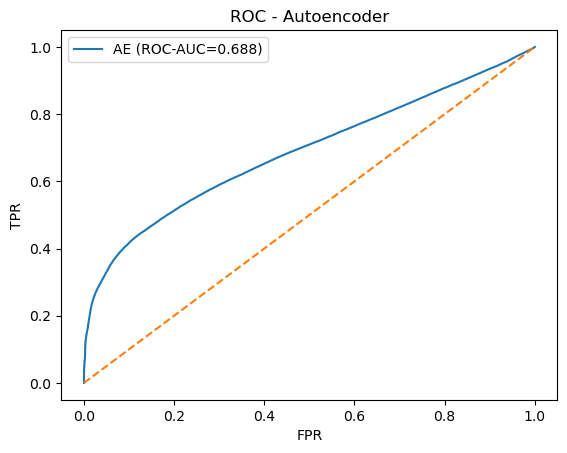

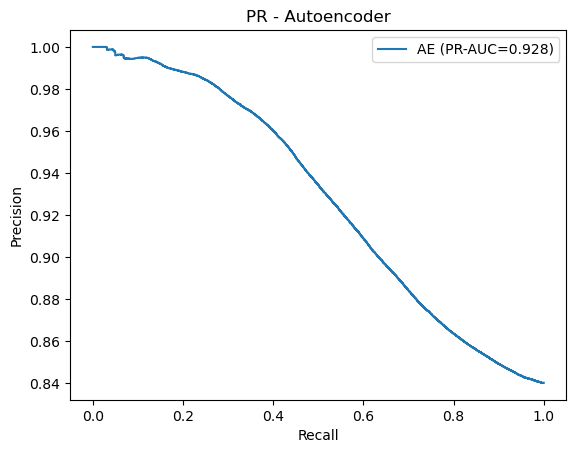

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve

fpr, tpr, _ = roc_curve(y_test, test_err)
plt.figure()
plt.plot(fpr, tpr, label=f'AE (ROC-AUC={roc_auc:.3f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC - Autoencoder'); plt.legend()

prec, rec, _ = precision_recall_curve(y_test, test_err)
plt.figure()
plt.plot(rec, prec, label=f'AE (PR-AUC={pr_auc:.3f})')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('PR - Autoencoder'); plt.legend()


In [22]:
def precision_at_k(scores, y_true, k_frac=0.01):
    k = max(1, int(k_frac * len(scores)))
    idx = np.argsort(scores)[::-1]   
    top = idx[:k]
    return y_true.values[top].mean()

print("AE Precision@1%:", precision_at_k(test_err, y_test, 0.01))
print("IF Precision@1%:", precision_at_k(scores_if,  y_test, 0.01))
print("LOF Precision@1%:",precision_at_k(scores_lof, y_test, 0.01))


AE Precision@1%: 1.0
IF Precision@1%: 0.9966130397967824
LOF Precision@1%: 0.9997177533163986
